In [4]:
import pandas as pd
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
# from nilearn import image
# import ants
from datetime import datetime, timedelta
# import pydicom as dicom
from glob import glob
import pickle
import matplotlib.image as mpimg
from collections import defaultdict, Counter
from scipy import stats

# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', None)

In [5]:
"""
    Process labels, with consideration of previous diagnoses.
"""
def process_records(df_label):
    pat_label_dict = defaultdict(str)

    # Return worst label for a diagnosis
    def identify_worst_label(x):
        if x.AD:
            return 'AD'
        elif x.MCI:
            return 'MCI'
        elif x.CN:
            return 'CN'
    
    for idx, row in df_label.iterrows():
        if row.random_pat_id not in pat_label_dict:
            temp = identify_worst_label(row)
            if temp:
                pat_label_dict[row.random_pat_id] = temp
        else:
            if pat_label_dict[row.random_pat_id] == 'AD':
                # When we observe AD before, the patient cannot return to CN, so we change the status to AD
                if row.CN: 
                    df_label.loc[idx, 'CN'] = 0
                    df_label.loc[idx, 'AD'] = 1
                # No label. In this case, we grant it AD.
                if row.CN + row.MCI + row.AD == 0:
                    df_label.loc[idx, 'AD'] = 1
            elif pat_label_dict[row.random_pat_id] == 'MCI':
                # When we observe MCI before, the patient cannot return to CN, so we change the status to MCI
                if row.CN: 
                    df_label.loc[idx, 'CN'] = 0
                    df_label.loc[idx, 'MCI'] = 1
                # No label. In this case, we grant it MCI.
                if row.CN + row.MCI + row.AD == 0:
                    df_label.loc[idx, 'MCI'] = 1
            elif pat_label_dict[row.random_pat_id] == 'CN':
                # No label. In this case, we grant it CN.
                if row.CN + row.MCI + row.AD == 0:
                    df_label.loc[idx, 'CN'] = 1
                else: # Update label
                    pat_label_dict[row.random_pat_id] = identify_worst_label(row)
    
    # Remove entries with no label. Such entries should be that no prior diagnoses made for the patient.
    return df_label[df_label[['CN', 'MCI', 'AD']].sum(axis=1) != 0]

'''
    Find mode label of a scan.
    Break tie by returning worse diagnoses
'''
def label_mode_func(x):
    res = Counter(x)
    ans, cur_count = 0, 0
    
    for label, count in sorted(res.items(), key=lambda x:x[0]):
        if count >= cur_count:
            ans = label
            cur_count = count
    
    return ans

# Transform label columns to one column. 0=CN, 1=MCI, 2=AD.
def get_label(x):
    if x.CN:
        return 0
    elif x.MCI:
        return 1
    elif x.AD:
        return 2
    else:
        raise Exception('No label for the row.')

In [6]:
# Load original dataframe. Shape=(41132, 133)
df = pd.read_csv('/gpfs/data/razavianlab/data/mri/nyu/barlow_niigz/labels_ehr/de_id_MRIs_Specialists_diag.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.visit_date = df.visit_date.apply(pd.to_datetime)
df.scan_date_time = df.scan_date_time.apply(pd.to_datetime)

print(df.shape)

# preserve only patients older than 55. Shape=(29991, 133)
df2 = df[df.Age >= 55]

print(df2.shape)

# Transform label
df_label_col_name = ['random_pat_id', 'scan_date_time', 'de-identified acc', 'visit_date', 'Any Dementia', 'Mild cognitive Impairment', 'Any Alzheimer\'s Disease']
df_label = df2.loc[:, df_label_col_name]
df_label['CN'] = (df2['Any Dementia'] == False).astype(int)
df_label['MCI'] = (df2['Mild cognitive Impairment'] == True).astype(int)
df_label['AD'] = (df2['Any Alzheimer\'s Disease'] == True).astype(int)
df_label.drop(['Any Dementia', 'Mild cognitive Impairment', 'Any Alzheimer\'s Disease'], axis=1, inplace=True)

print(df_label.shape)

# If one has multiple label, transform it
df_label.loc[df_label.CN + df_label.MCI == 2, 'CN'] = 0
df_label.loc[df_label.MCI + df_label.AD == 2, 'AD'] = 0
df_label.loc[df_label.CN + df_label.AD == 2, 'CN'] = 0

# Process records with consideration of previous diagnoses. Remove entries with no labels. At this point, all rows should have exactly 1 diagnosis
df_label = process_records(df_label)

print(df_label.shape)

# +- 6 month (5413, 7)
df_label = df_label[(pd.Timedelta(days=-180) < df_label.scan_date_time - df_label.visit_date) & (df_label.scan_date_time - df_label.visit_date < pd.Timedelta(days=180))]

print(df_label.shape)

# Get label for each scan by the mode of diagnoses (with tie breaker). Shape=(6854, 4)
df_label['label'] = df_label.apply(lambda x: get_label(x), axis=1)
print('Visits before/after 180 days of a scan.')
print(df_label.groupby('de-identified acc').size().value_counts())

df_label_label_with_mode = df_label[['de-identified acc', 'label']].groupby('de-identified acc').agg(lambda x: label_mode_func(x))
df_label = pd.merge(df_label[['random_pat_id', 'scan_date_time', 'de-identified acc']].groupby('de-identified acc').nth(0), df_label_label_with_mode, left_index=True, right_index=True).reset_index()

print(df_label.shape)

(41132, 133)
(29991, 133)
(29991, 7)
(28620, 7)
(5190, 7)
Visits before/after 180 days of a scan.
1    1726
2    1200
3     334
dtype: int64
(3261, 4)


In [7]:
print(df_label.groupby('de-identified acc').size().value_counts())
print(df_label.groupby('random_pat_id').size().value_counts())


1    3259
2       1
dtype: int64
1     1287
2      355
3      119
4       58
5       32
6       19
10       8
9        7
7        7
8        5
13       4
12       4
14       3
16       1
11       1
dtype: int64


In [37]:
df_label.drop('scan_date_time', axis=1, inplace=True)


In [6]:
df_label['de-identified acc'] = df_label['de-identified acc'].astype(int)
df_label

,de-identified acc,random_pat_id,scan_date_time,label
0,100027089657,f37b1d2e3cec40ba88ec39be79577f65,2014-06-17 10:43:00,1
1,100039817943,210909b9725245c5a09e052b931447f4,2016-03-17 10:19:00,0
2,100086429574,ad32654d20f345b0bab70ffba08df770,2020-03-09 14:32:00,1
3,100166373876,bcc51523e7014bdda6b5867de8e7a6a5,2015-05-22 10:18:00,2
4,100197260038,d8200ab1eb464d72998f497732d921a3,2017-06-08 09:33:00,1
...,...,...,...,...
3255,997728775571,d71ac2a05099410b82d8a070b59ec48d,2014-03-05 15:51:00,0
3256,998819920173,bbc73dd2480442108e5307511a1b9b75,2015-06-08 19:25:00,1
3257,999155686841,b3ddd61266c842a9b98597579f1054df,2018-11-14 13:00:00,0
3258,999370949215,4813b0173c2544f3b0bd987300cb8021,2014-01-15 16:14:00,2


In [43]:
df_label.to_csv('/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/experiments/20211102/label_20211102.tsv', index=False, sep='\t')

In [28]:
df_label.random_pat_id.unique().shape

(1910,)

In [6]:
print('Number of sessions per patient')
print(df_label.groupby('random_pat_id').size().value_counts())

Number of sessions per patient
1     1287
2      355
3      120
4       57
5       32
6       19
10       8
9        7
7        7
8        5
12       4
13       4
14       3
16       1
11       1
dtype: int64


In [46]:
df_s = df_label.groupby('random_pat_id').size()
df_s[df_s == 16]

random_pat_id
c3c9b03bd3a34702ba236fca4051394c    16
dtype: int64

In [7]:
df_label[df_label.random_pat_id == '1ef4d27d69264e11b0fc6053478a763a']

,de-identified acc,random_pat_id,scan_date_time,label
822,1.792667e+11,1ef4d27d69264e11b0fc6053478a763a,2017-07-07 07:54:00,1
904,1.864842e+11,1ef4d27d69264e11b0fc6053478a763a,2017-02-15 07:48:00,1
1066,2.003105e+11,1ef4d27d69264e11b0fc6053478a763a,2016-10-13 18:33:00,1
1095,2.039539e+11,1ef4d27d69264e11b0fc6053478a763a,2017-06-27 12:20:00,1
1107,2.052813e+11,1ef4d27d69264e11b0fc6053478a763a,2016-03-02 12:52:00,1
1908,2.822510e+11,1ef4d27d69264e11b0fc6053478a763a,2016-01-20 12:09:00,1
1960,2.868746e+11,1ef4d27d69264e11b0fc6053478a763a,2017-04-12 11:46:00,1
2087,2.977252e+11,1ef4d27d69264e11b0fc6053478a763a,2016-03-09 07:51:00,1
2278,3.191263e+11,1ef4d27d69264e11b0fc6053478a763a,2016-05-11 11:34:00,1
2330,3.236583e+11,1ef4d27d69264e11b0fc6053478a763a,2017-02-13 12:39:00,1


In [8]:
print('Label counts')
print(df_label.label.value_counts())

Label counts
0    1475
1    1429
2     356
Name: label, dtype: int64


In [34]:
df_label.iloc[1000, 0]

194151323632.0

In [65]:
file_path = glob('/gpfs/data/razavianlab/data/mri/nyu/barlow_niigz/data/*/*/*.nii.gz')
barlow_file_df = pd.DataFrame([(x.split('/')[9], x) for x in file_path], columns=['Session', 'Path'])
barlow_file_df.head(3)
barlow_file_df = barlow_file_df[barlow_file_df.Session != '']
# barlow_file_df

In [67]:
barlow_file_df = barlow_file_df[~barlow_file_df.Session.str.contains('unmapped', na=False)]

In [68]:
barlow_file_df.Session = barlow_file_df.Session.astype(int)
df_label_with_file_info.Session = df_label_with_file_info.Session.astype(int)

In [69]:
df_label.rename({'random_pat_id': 'Subject', 'de-identified acc': 'Session'}, axis=1, inplace=True)


In [72]:
df_label_with_file_info = barlow_file_df.merge(df_label, on='Session', how='left')
# df_label_with_file_info.drop(['participant_id', 'session_id'], axis=1, inplace=True)
# df_label_with_file_info.dropna(inplace=True)
# df_label_with_file_info.drop(['de-identified acc', 'random_pat_id', 'scan_date_time'], axis=1, inplace=True)
df_label_with_file_info.dropna(axis=0, inplace=True)
df_label_with_file_info.to_csv('all_file_path_with_label.tsv', index=False, sep='\t')

In [81]:
df_label_with_file_info.head(5)

,Session,Path,Subject,scan_date_time,label
102,184581554731,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,9a6f5a563d024e619747523c05ad6cec,2016-09-26 16:14:00,1.0
103,184581554731,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,9a6f5a563d024e619747523c05ad6cec,2016-09-26 16:14:00,1.0
104,184581554731,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,9a6f5a563d024e619747523c05ad6cec,2016-09-26 16:14:00,1.0
105,184581554731,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,9a6f5a563d024e619747523c05ad6cec,2016-09-26 16:14:00,1.0
106,184581554731,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,9a6f5a563d024e619747523c05ad6cec,2016-09-26 16:14:00,1.0


In [56]:
999471706129 / 9999070215

99.95646441502662

In [77]:
# Get only T1 files
image_flavor_file = pd.read_csv('/gpfs/home/lc3424/capstone/2021_dementia/notebooks/data/Brain Contrast Flavors.csv')
t1_flavors = image_flavor_file['T1 3D (MPRAGE) (PRE/Unspecied or POST)'].dropna()
t1_flavor_list = t1_flavors.apply(lambda x:x.replace(' ', '_').lower()).tolist()
t1_flavor_list

['sag_3d-t1-ms-p',
 't1_3d',
 'sag_3d_t1_-_ms-p',
 't1_mprage_tra_iso_1.0',
 't1_mprage_axial_post',
 'sag_3d_t1_tfe',
 'sag_t1_isofse_3d_+c',
 '3d-t1-ms-p',
 'ax_t1_3d_mpr',
 'sag_t1_isofse_3d',
 '3d-t1-ms-p_pre',
 'sag_3d_mpr',
 'sag_mpr',
 'ax_3d_mpr',
 'ax_mpr',
 'sag_mpr_pre']

In [83]:
df_res = []
for idx, row in df_label_with_file_info.iterrows():
    if any([(x in row.Path.lower()) for x in t1_flavor_list]):
        df_res.append(row)

final_df = pd.DataFrame(np.array(df_res), columns=df_label_with_file_info.columns)
final_df.to_csv('t1_file_path_with_label.tsv', index=False, sep='\t')

In [27]:
output_dir = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1'
final_df.dest_path = final_df.apply(lambda x: os.path.join(output_dir, 'sub-{}/'.format(x[1]), 'ses-{}/'.format(int(x[0])), 'anat', x[6].split('/')[-1]), axis=1)
final_df.to_csv('/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/' + 'file_migration_table_t1_v1.tsv', index=False, sep='\t')

In [28]:
final_df['de-identified acc'].unique().shape

(4519,)

(256, 256, 65)

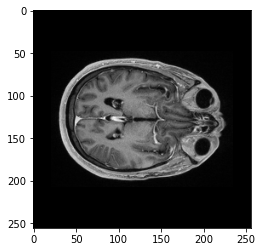

In [14]:
data_path = "/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1/sub-7dd12f7e589b4542989d21d0e899c29b/ses-882761424397/anat"
patient_id = ""
file_name = "sub-7dd12f7e589b4542989d21d0e899c29b_ses-882761424397_20091205-AX_MPR_RECON-100.nii.gz"

example_filename = os.path.join(data_path, patient_id, file_name)
file = nib.load(example_filename)
img = file.get_fdata()
plt.imshow(img[:,:,32], cmap='gray')
img.shape

(160, 216, 256)

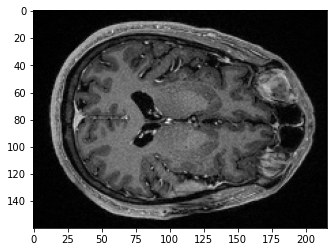

In [13]:
data_path = "/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1/sub-7dd12f7e589b4542989d21d0e899c29b/ses-882761424397/anat"
patient_id = ""
file_name = "sub-7dd12f7e589b4542989d21d0e899c29b_ses-882761424397_20091205-SAG_3D_MPR-13.nii.gz"

example_filename = os.path.join(data_path, patient_id, file_name)
file = nib.load(example_filename)
img = file.get_fdata()
plt.imshow(img[:,:,128], cmap='gray')
img.shape

(484, 484, 1)

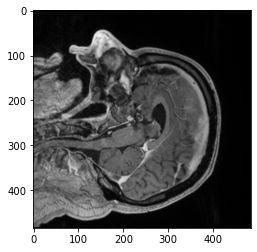

In [10]:
f = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1/sub-01875353714a476090710e1bd5d2d88d/ses-137652431739_2/anat/sub-01875353714a476090710e1bd5d2d88d_ses-137652431739_2_20090213-AX_MPR_RECON-102c_T1w.nii.gz'
file = nib.load(f)
img = file.get_fdata()
plt.imshow(img[:,:,0], cmap='gray')
img.shape

(256, 256, 59)

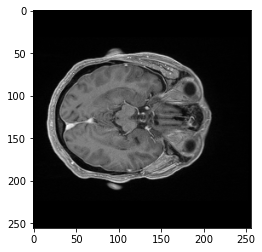

In [12]:
f = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1/sub-01875353714a476090710e1bd5d2d88d/ses-137652431739_2/anat/sub-01875353714a476090710e1bd5d2d88d_ses-137652431739_2_20090213-AX_MPR_RECON-102_T1w.nii.gz'
file = nib.load(f)
img = file.get_fdata()
plt.imshow(img[:,:,24], cmap='gray')
img.shape

(256, 256, 59)

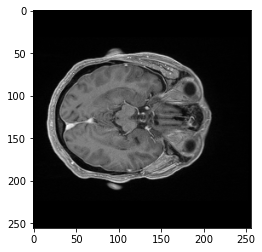

In [14]:
f = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1/sub-01875353714a476090710e1bd5d2d88d/ses-137652431739_2/anat/sub-01875353714a476090710e1bd5d2d88d_ses-137652431739_2_20090213-AX_MPR_RECON-102b_T1w.nii.gz'
file = nib.load(f)
img = file.get_fdata()
plt.imshow(img[:,:,24], cmap='gray')
img.shape

(121, 145, 121)

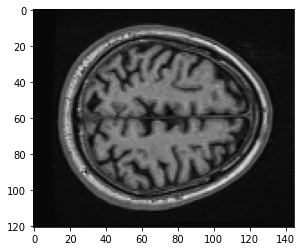

In [22]:
f = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1_preprocess_A_part_a/subjects/sub-0a2b22da7f004536adef5ac670d443c2/ses-184837540961/t1/spm/segmentation/normalized_space/sub-0a2b22da7f004536adef5ac670d443c2_ses-184837540961_20111111-SAG_MPR-2_space-Ixi549Space_T1w.nii.gz'
f2 = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1_preprocess_A_part_a/subjects/sub-0a2b22da7f004536adef5ac670d443c2/ses-184837540961/t1/spm/segmentation/normalized_space/sub-0a2b22da7f004536adef5ac670d443c2_ses-184837540961_20111111-SAG_MPR-2_T1w_segm-csf_space-Ixi549Space_modulated-off_probability.nii.gz'
f3 = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1_preprocess_A_part_a/subjects/sub-0a2b22da7f004536adef5ac670d443c2/ses-184837540961/t1/spm/segmentation/normalized_space/sub-0a2b22da7f004536adef5ac670d443c2_ses-184837540961_20111111-SAG_MPR-2_T1w_target-Ixi549Space_transformation-forward_deformation.nii.gz'
file = nib.load(f)
img = file.get_fdata()
plt.imshow(img[:,:,80], cmap='gray')
img.shape

In [10]:
df = pd.read_csv('/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/file_migration_table_t1_v4.tsv', sep='\t')

In [14]:
df

,Unnamed: 0,sess_info,file_type,de-identified acc,random_pat_id,scan_date_time,label,orig_path,dest_path
0,1,-20150220-AX_3D_MPR-22,niigz,2.595211e+11,5c2f5ed8aeee4c4ba21955ce3b148740,2017-06-03 12:30:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_niigz/data/259521128826/-20150220-AX_3D_MPR-22/-20150220-AX_3D_MPR-22.nii.gz,20150220-AX_3D_MPR-22.nii.gz
1,3,-20150220-SAG_MPR_RECON_1MM-23,niigz,2.595211e+11,5c2f5ed8aeee4c4ba21955ce3b148740,2017-06-03 12:30:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_niigz/data/259521128826/-20150220-SAG_MPR_RECON_1MM-23/-20150220-SAG_MPR_RECON_1MM-23.nii.gz,20150220-SAG_MPR_RECON_1MM-23.nii.gz
2,5,1003422834-20080613-AX_3D_MPR_ISO-13,niigz,7.862150e+11,644e107e27d540c2a65f159f45fbfe81,2015-08-27 09:56:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_niigz/data/786215002605/1003422834-20080613-AX_3D_MPR_ISO-13/1003422834-20080613-AX_3D_MPR_ISO-13.nii.gz,20080613-AX_3D_MPR_ISO-13.nii.gz
3,7,1003422834-20080613-AX_MPR_RECON-101,niigz,7.862150e+11,644e107e27d540c2a65f159f45fbfe81,2015-08-27 09:56:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_niigz/data/786215002605/1003422834-20080613-AX_MPR_RECON-101/1003422834-20080613-AX_MPR_RECON-101.nii.gz,20080613-AX_MPR_RECON-101.nii.gz
4,9,1003422834-20080613-SAG_MPR_RECON-103,niigz,7.862150e+11,644e107e27d540c2a65f159f45fbfe81,2015-08-27 09:56:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_niigz/data/786215002605/1003422834-20080613-SAG_MPR_RECON-103/1003422834-20080613-SAG_MPR_RECON-103.nii.gz,20080613-SAG_MPR_RECON-103.nii.gz
...,...,...,...,...,...,...,...,...,...
10523,21047,9999070215-20190719-AX_MPR-16001,niigz,3.160603e+11,16a191ad3fae43ac9be96c18cd86194a,2020-09-16 09:34:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_niigz/data/316060303146/9999070215-20190719-AX_MPR-16001/9999070215-20190719-AX_MPR-16001.nii.gz,20190719-AX_MPR-16001.nii.gz
10524,21049,9999070215-20190719-AX_MPR_MPR_cor_recon-17001,niigz,3.160603e+11,16a191ad3fae43ac9be96c18cd86194a,2020-09-16 09:34:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_niigz/data/316060303146/9999070215-20190719-AX_MPR_MPR_cor_recon-17001/9999070215-20190719-AX_MPR_MPR_cor_recon-17001.nii.gz,20190719-AX_MPR_MPR_cor_recon-17001.nii.gz
10525,21051,9999070215-20190719-AX_MPR_MPR_sag_recon-18001,niigz,3.160603e+11,16a191ad3fae43ac9be96c18cd86194a,2020-09-16 09:34:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_niigz/data/316060303146/9999070215-20190719-AX_MPR_MPR_sag_recon-18001/9999070215-20190719-AX_MPR_MPR_sag_recon-18001.nii.gz,20190719-AX_MPR_MPR_sag_recon-18001.nii.gz
10526,21053,9999070215-20191225-AX_3D_MPR-13,niigz,2.585815e+11,16a191ad3fae43ac9be96c18cd86194a,2021-02-22 08:20:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_niigz/data/258581530159/9999070215-20191225-AX_3D_MPR-13/9999070215-20191225-AX_3D_MPR-13.nii.gz,20191225-AX_3D_MPR-13.nii.gz


In [89]:
final_df.iloc[1,1].split('/')[-1]

'3392748788-20061105-SAG_MPR_MPR_Tra-15_Eq_1.nii.gz'

In [94]:
final_df.loc[:, 'dest_path'] = final_df.Path.apply(lambda x: x.split('/')[-1])

In [96]:
final_df.to_csv('t1_file_path_with_label.tsv', index=False, sep='\t')

In [84]:
df1 = pd.read_csv('/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/file_migration_table_t1_v4.tsv', sep='\t')
df1

,Unnamed: 0,sess_info,file_type,de-identified acc,random_pat_id,scan_date_time,label,orig_path,dest_path
0,1,-20150220-AX_3D_MPR-22,niigz,2.595211e+11,5c2f5ed8aeee4c4ba21955ce3b148740,2017-06-03 12:30:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,20150220-AX_3D_MPR-22.nii.gz
1,3,-20150220-SAG_MPR_RECON_1MM-23,niigz,2.595211e+11,5c2f5ed8aeee4c4ba21955ce3b148740,2017-06-03 12:30:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,20150220-SAG_MPR_RECON_1MM-23.nii.gz
2,5,1003422834-20080613-AX_3D_MPR_ISO-13,niigz,7.862150e+11,644e107e27d540c2a65f159f45fbfe81,2015-08-27 09:56:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,20080613-AX_3D_MPR_ISO-13.nii.gz
3,7,1003422834-20080613-AX_MPR_RECON-101,niigz,7.862150e+11,644e107e27d540c2a65f159f45fbfe81,2015-08-27 09:56:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,20080613-AX_MPR_RECON-101.nii.gz
4,9,1003422834-20080613-SAG_MPR_RECON-103,niigz,7.862150e+11,644e107e27d540c2a65f159f45fbfe81,2015-08-27 09:56:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,20080613-SAG_MPR_RECON-103.nii.gz
5,11,1003422834-20081003-AX_MPR_3MM-104,niigz,1.374765e+11,644e107e27d540c2a65f159f45fbfe81,2015-12-17 14:50:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,20081003-AX_MPR_3MM-104.nii.gz
6,13,1003422834-20081003-SAG_3D_MPR-17,niigz,1.374765e+11,644e107e27d540c2a65f159f45fbfe81,2015-12-17 14:50:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,20081003-SAG_3D_MPR-17.nii.gz
7,15,1003422834-20081003-SAG_MPR_3MM-103,niigz,1.374765e+11,644e107e27d540c2a65f159f45fbfe81,2015-12-17 14:50:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,20081003-SAG_MPR_3MM-103.nii.gz
8,17,1003422834-20090206-AX_MPR_RECON-100,niigz,2.701453e+11,644e107e27d540c2a65f159f45fbfe81,2016-04-21 12:17:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,20090206-AX_MPR_RECON-100.nii.gz
9,19,1003422834-20090206-SAG_3D_MPR-12,niigz,2.701453e+11,644e107e27d540c2a65f159f45fbfe81,2016-04-21 12:17:00,0,/gpfs/data/razavianlab/data/mri/nyu/barlow_nii...,20090206-SAG_3D_MPR-12.nii.gz


In [87]:
df1['de-identified acc'].isin(final_df.Session.tolist()).sum()

4904